Imports and preparation

In [1]:
#Imports
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from skimage import measure
from statistics import mean

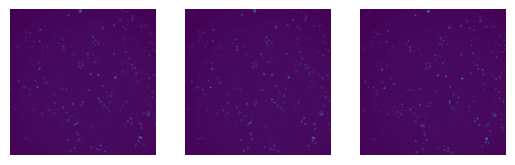

In [2]:
#Import the original images
images_path = str(os.getcwd()) + '\\data_for_cellpose\\'
onlyfiles = [f for f in listdir(images_path) if isfile(join(images_path, f)) and f.endswith('.tiff')]
images = [np.squeeze(tifffile.imread(images_path +  onlyfiles[i])) for i in range(len(onlyfiles))]

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

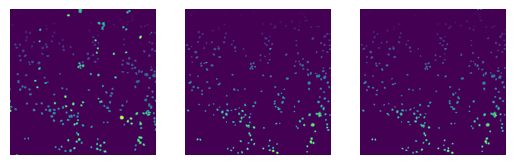

In [3]:
#Import the groundtruth masks
instance_masks_path = str(os.getcwd()) + '\\data_for_cellpose\\'
onlyfiles = [f for f in listdir(images_path) if isfile(join(images_path, f)) and f.endswith('.npy')]
gt_instance_masks = [np.load(instance_masks_path + onlyfiles[i], allow_pickle=True).item()['masks'] for i in range(len(onlyfiles))]
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(gt_instance_masks[i])
    plt.axis('off')
plt.show()

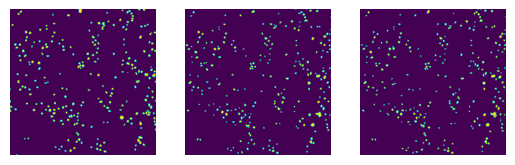

In [4]:
#Binarise the groundtruth masks
binary_gt_instance_masks = [np.where(gt_instance_masks[i] > 0, 1, 0) for i in range(len(gt_instance_masks))]
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(binary_gt_instance_masks[i])
    plt.axis('off')
plt.show()

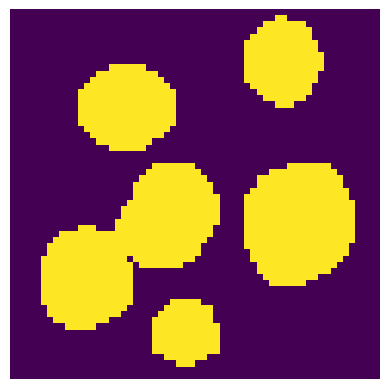

In [5]:
#display 20 random crops of 200 by 200 pixels of the first binary groundtruth mask
x = 354+31
y = 490+4

#[[11.93846154 89.93846154]
# [39.         47.65384615]
# [46.45333333 22.46666667]
# [64.22330097 29.11650485]
# [65.22292994 50.28025478]
# [74.01010101 15.95959596]
# [82.88461538 31.96153846]]

plot = binary_gt_instance_masks[0][x:x+60, y:y+60]
plt.imshow(plot)
plt.axis('off')
plt.savefig("saved_images/binary mask.png",bbox_inches='tight')
plt.show()

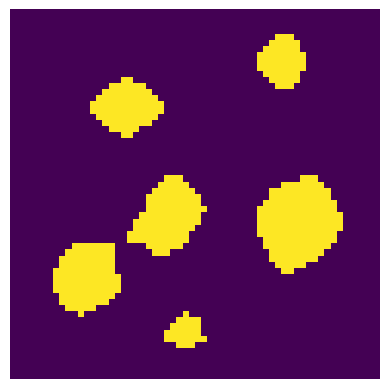

In [6]:
import cv2

kernel = np.ones((5, 5), np.uint8)
erosion = cv2.erode(plot.astype('uint8'), kernel, iterations=1)

plt.imshow(erosion)
plt.axis('off')
plt.savefig("saved_images/binary mask eroded.png",bbox_inches='tight')
plt.show()

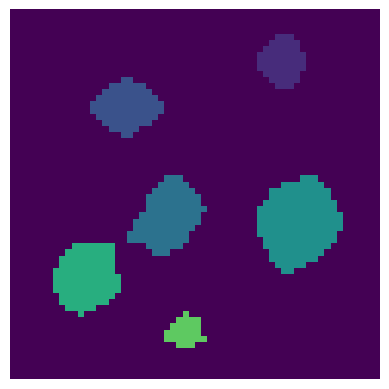

In [7]:
#for every pixel in erosion, if it is equals to 1 and a pixel around it is also equalt to 1, then they are labelled the same unique number
labels = measure.label(erosion, connectivity=2)
plt.imshow(labels,vmin=0, vmax=8)
plt.axis('off')
plt.savefig("saved_images/instance mask eroded.png",bbox_inches='tight')
plt.show()

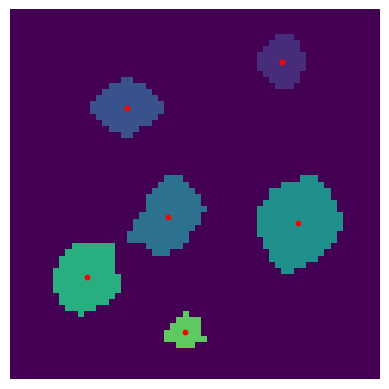

In [8]:
#plot labels and the centers of each values except 0
#get the centers of each values except 0
#for each unique value in labels, get the mean of the x and y coordinates of the pixels that have that value
centers = np.array([np.mean(np.where(labels == i), axis=1) for i in np.unique(labels) if i != 0])
#scatter plots the centers in red
plt.scatter(centers[:,1], centers[:,0], c='r', s=10)
#plot the labels
plt.imshow(labels,vmin=0, vmax=8)
plt.axis('off')
plt.savefig("saved_images/instance mask eroded centers.png",bbox_inches='tight')
plt.show()

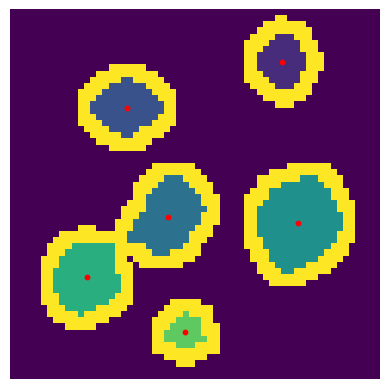

In [9]:
#if a pixel was eroded in plot, add it back on labels
labels_copy = labels.copy()
for i in range(60):
    for j in range(60):
        if plot[i][j] == 1 and labels_copy[i][j] == 0:
            labels_copy[i][j] = 8
plt.scatter(centers[:,1], centers[:,0], c='r', s=10)
plt.imshow(labels_copy,vmin=0, vmax=8)
plt.axis('off')
plt.savefig("saved_images/instance mask uneroded.png",bbox_inches='tight')
plt.show()

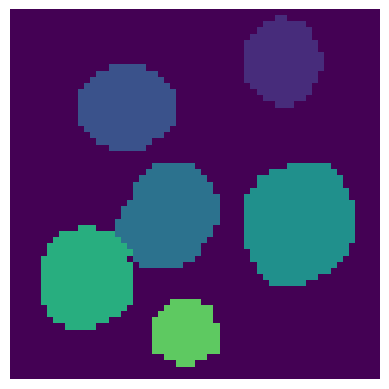

In [10]:
#if a pixel has the value 8, label it with the value of the center that is closest to it
for i in range(60):
    for j in range(60):
        if labels_copy[i][j] == 8:
            distances = np.sqrt((centers[:,0] - i)**2 + (centers[:,1] - j)**2)
            labels_copy[i][j] = np.unique(labels_copy)[np.argmin(distances)+1]
plt.imshow(labels_copy,vmin=0, vmax=8)
plt.axis('off')
plt.savefig("saved_images/instance mask final.png",bbox_inches='tight')
plt.show()

In [11]:
def binary_to_instance_mask(binary_mask):
    #We first erode the mask to unconnect touching cell masks
    kernel = np.ones((5, 5), np.uint8)
    erosion = cv2.erode(binary_mask.astype('uint8'), kernel, iterations=1)

    #We then give a unique number to each cluster
    instances = measure.label(erosion, connectivity=2)

    #We calculate the center of each cluster
    cluster_centers = np.array([np.mean(np.where(labels == i), axis=1) for i in np.unique(labels) if i != 0])
    
    for i in range(len(binary_mask)):
        print(i)

        for j in range(len(binary_mask)):
            if binary_mask[i][j] == 1 and instances[i][j] == 0:
                distances = np.sqrt((cluster_centers[:,0] - i)**2 + (cluster_centers[:,1] - j)**2)
                instances[i][j] = np.unique(instances)[np.argmin(distances)+1]
                
    return instances

In [57]:
import numpy as np
import numba as nb

@nb.jit(nopython=True)
def compute_distances(cluster_centers, i, j):
    return np.sqrt((cluster_centers[:, 0] - i)**2 + (cluster_centers[:, 1] - j)**2)

def compute_instances(binary_mask, instances, cluster_centers):
    unique_instances = np.unique(instances)
    print(unique_instances)
    count = 0
    print(np.unique(instances,return_counts=True)[1][0])
    for i in range(len(binary_mask)):
        #print(i)
        for j in range(len(binary_mask)):
            if binary_mask[i][j] == 1 and instances[i][j] == 0:
                distances = compute_distances(cluster_centers, i, j)
                count += 1
                #print(distances)
                instances[i][j] = unique_instances[np.argmin(distances) + 1]
    print(np.unique(instances,return_counts=True)[1][0])

    
    print(count)
    return instances


def binary_to_instance_mask(binary_mask):
    #We first erode the mask to unconnect touching cell masks
    kernel = np.ones((5, 5), np.uint8)
    erosion = cv2.erode(binary_mask.astype('uint8'), kernel, iterations=1)

    #We then give a unique number to each cluster
    instances = measure.label(erosion, connectivity=2)

    #We calculate the center of each cluster
    cluster_centers = np.array([np.mean(np.where(instances == i), axis=1) for i in np.unique(instances) if i != 0])
    print('labels',np.unique(instances))
    print('lengthf of cluster centers',len(cluster_centers))
    
    instances = compute_instances(binary_mask, instances, cluster_centers)
                
    return instances

In [58]:
instance_mask = binary_to_instance_mask(binary_gt_instance_masks[0][100:-100, 100:-100])

labels [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170]
lengthf of cluster centers 170
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65

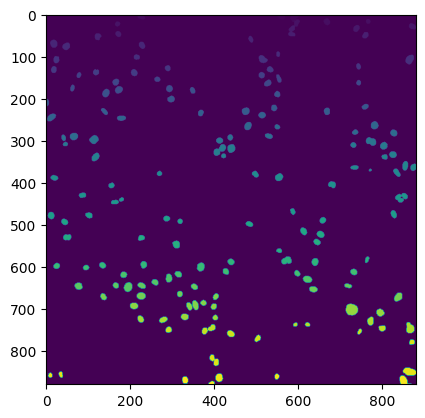

In [59]:
plt.imshow(instance_mask)

In [60]:
#Get our instances algorithm
def instance_seg_alg(binary_mask):
    return measure.label(binary_mask, background=0,connectivity=1)

Quantitative analysis

labels [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

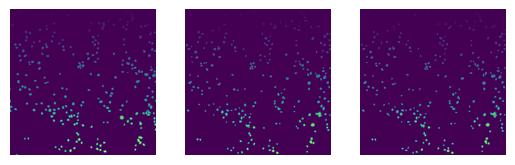

In [61]:
#Get the instance segmentation on the binary masks
instance_masks = [binary_to_instance_mask(binary_gt_instance_masks[i]) for i in range(len(binary_gt_instance_masks))]
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(instance_masks[i])
    plt.axis('off')
plt.show()

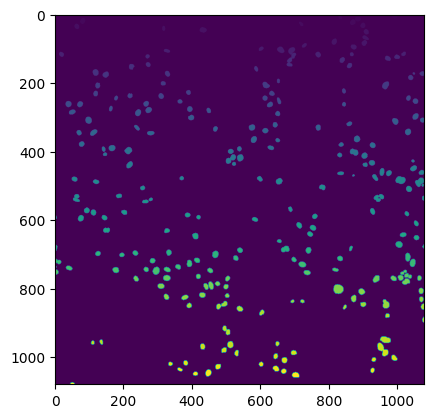

In [64]:
plt.imshow(instance_masks[0])

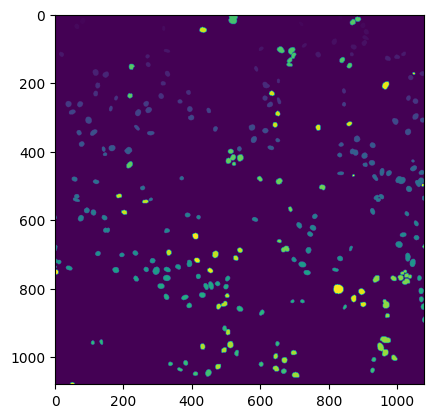

In [18]:
plt.imshow(gt_instance_masks[0])

In [66]:
#Get the difference in number of cells found
num_cells = np.array([np.max(instance_masks[i]) for i in range(len(instance_masks))])
num_gt_cells = np.array([np.max(gt_instance_masks[i]) for i in range(len(gt_instance_masks))])
print('Found cells on average compared to the groundtruth',str(round(mean(num_cells/num_gt_cells)*100,2))+'%')

Found cells on average compared to the groundtruth 95.91%


In [93]:
#We now have info to compare which method finds more cell masks, which can be wrong or right
#Conclusion: we find less masks in general than the ground truth one, but very very close to it still

In [20]:
print(len(images))

24


In [108]:
print(images[1].shape)

(1080, 1080)


Qualitative analysis

In [23]:
#Get 108x108 crops of the original images (make them smaller if not precise enough)
crop_size = 10
n_crops = images[0].shape[0] // crop_size
image_crops = []
gt_im_crops = []
im_crops = []
for k in range(len(images)):
    for i in range(n_crops):
        for j in range(n_crops):
            image_crop = images[k][i*crop_size:(i+1)*crop_size, j*crop_size:(j+1)*crop_size]
            im_crop = instance_masks[k][i*crop_size:(i+1)*crop_size, j*crop_size:(j+1)*crop_size]
            gt_im_crop = gt_instance_masks[k][i*crop_size:(i+1)*crop_size, j*crop_size:(j+1)*crop_size]
            if len(np.where(im_crop > 0)[0]) < 1500:
                continue

            im_crops.append(im_crop)
            image_crops.append(image_crop)
            gt_im_crops.append(gt_im_crop)
print(len(image_crops),len(im_crops),len(gt_im_crops))
#Select the indexes of crop that look like they have a lot of cells and would be interesting to segment

0 0 0


In [24]:
for i in range(len(im_crops)):
    plt.subplot(1,3,1)
    plt.imshow(image_crops[i])
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_crops[i       ])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(gt_im_crops[i])
    plt.axis('off')
    plt.show()

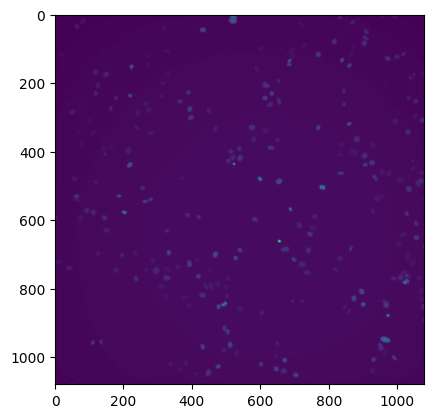

In [134]:
plt.imshow(images[0])

725 696
493 380
926 305
403 170
542 223
143 270
888 595
386 442
505 134
626 530
275 502
790 810
912 544
234 390
277 966
11 436
776 604
715 314
563 960
443 552
155 186
766 965
874 373
133 833
238 37
99 717
905 715
93 748
788 603
258 395
802 564
621 336
575 686
287 460
734 164
430 464
434 438
320 178
92 370
458 506
800 786
772 485
518 149
124 116
825 76
600 384
36 920
894 498
260 835
920 450
419 377
66 454
858 532
396 207
688 194
898 609
793 551
285 346
194 197
107 345
35 685
721 202
12 726
945 56
925 567
414 701
27 521
178 703
590 591
157 86
775 70
546 307
867 123
243 404
334 600
94 886
210 547
926 867
777 722
566 975
874 675
445 358
797 184
969 99
47 352
298 813
208 216
354 879
421 293
159 302
563 924
177 374
368 313
772 341
573 300
433 338
918 879
105 390
405 413
748 500
79 538
265 280
378 869
945 808
570 750
400 863
33 720
788 828
810 439
60 717
710 219
127 645
837 333
270 606
556 918
234 833
181 968
98 584
816 50
277 154
684 533
833 822
729 121
44 16
30 615
214 100
438 770
481 526
3

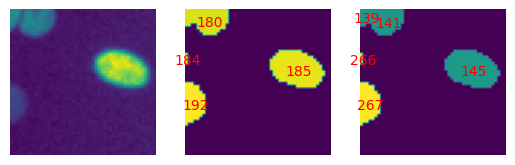

635 226
746 10
891 631
357 133
163 898
944 856
476 97
438 308
918 902
845 206
410 820
132 588
95 157
664 16
105 845
316 744
737 573
951 406
428 921
719 786
90 794
788 675
622 354
895 304
974 818
681 674
791 11
233 155
488 110
128 590
115 97
678 772
393 416
288 99
186 570
431 764
511 543
918 659
534 100
335 934
455 895
809 639
45 575
786 727
820 265
425 825
358 320
82 387
614 909
465 789
337 807
530 44
599 462
176 420
385 280
81 753
485 752
1 372
344 760
641 181
554 13
723 454
10 259
687 235
183 185
820 124
885 509
161 314
243 297
971 66
488 625
320 475
600 752
786 503
245 192
497 684
263 633
794 937
658 174
869 65
978 651
91 357
415 140
396 108
32 679
364 900
73 216
675 743
721 253
618 288
667 677
960 64
79 425
22 615
897 843
248 448
380 302
256 438
850 198
780 360
564 458
876 13
568 210
711 847
151 217
172 109
205 384
739 107
784 524
217 542
775 397
562 207
871 903
455 34
691 583
848 26
777 728
793 758
568 756
455 228
925 628
259 158
738 421
262 358
351 0
645 776
119 307
780 767
275 8

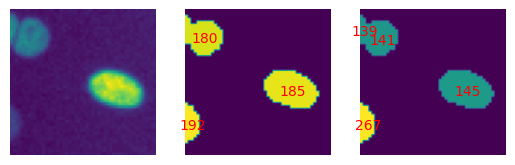

804 629
350 586
570 168
355 805
406 576
146 333
120 749
838 898
824 389
495 165
315 633
625 892
254 301
685 247
311 973
668 652
279 763
201 540
943 20
847 154
136 186
718 138
686 327
893 576
524 570
525 600
522 862
360 231
454 26
626 578
535 382
740 841
241 656
932 390
919 870
40 230
612 221
454 675
765 61
537 626
216 1
908 200
764 403
308 730
224 507
406 1
804 815
653 931
296 661
821 605
503 115
492 845
445 744
352 553
790 776
623 459
947 760
934 737
145 627
463 845
926 782
523 1
128 649
444 98
354 531
554 665
922 380
250 40
156 99
357 796
372 722
796 343
817 711
447 244
234 437
936 178
731 647
37 691
179 578
839 299
854 882
545 976
221 246
742 117
425 424
47 481
331 248
254 325
174 276
920 266
48 200
967 481
289 57
881 629
119 145
309 708
216 621
539 937
392 387
690 378
736 111
630 654
821 67
66 525
595 832
714 523
192 214
876 436
680 630
657 93
294 349
838 116
366 247
709 574
947 787
692 365
760 259
179 285
728 673
832 572
439 848
287 223
568 162
265 206
562 724
339 237
751 278
955 

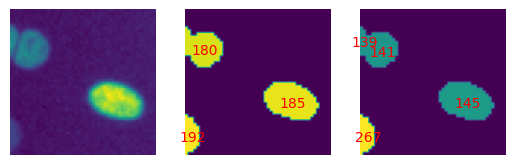

445 516
108 590
296 149
588 466
300 125
854 641
330 874
88 208
78 67
601 396
338 788
362 881
923 527
271 257
269 920
781 70
739 515
332 377
395 677
769 312
753 961
676 633
593 378
734 707
685 867
912 885
536 448
326 894
362 935
259 328
219 21
361 773
406 189
216 395
742 435
845 390
829 99
17 185
931 519
106 860
479 464
328 634
204 60
621 589
69 464
825 563
268 215
798 164
48 185
152 486
570 113
706 244
539 43
358 180
883 695
78 100
272 266
482 168
378 257
257 707
732 179
774 107
47 239
72 125
173 963
708 253
223 395
707 215
874 661
300 690
105 689
372 429
84 198
334 131
127 712
440 239
859 60
682 332
633 448
541 597
818 274
391 783
304 761
794 704
733 586
847 346
318 245
728 375
316 402
344 21
960 611
842 504
610 332
439 381
513 382
415 50
272 402
277 313
881 476
356 544
497 63
221 100
580 637
350 450
489 222
21 348
497 455
248 354
478 941
769 613
726 129
451 758
203 37
407 464
275 654
60 170
831 392
823 573
961 632
331 294
36 263
773 730
791 917
320 917
378 172
134 82
428 354
152 443


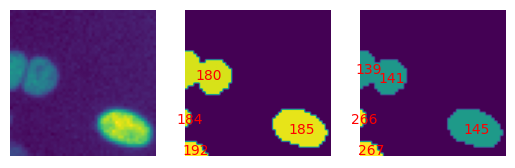

660 936
825 795
334 955
488 312
78 319
2 42
587 213
417 804
203 631
908 814
53 154
707 539
162 551
973 10
830 919
545 975
546 374
132 781
303 580
651 416
31 33
655 441
139 571
207 642
876 283
978 755
598 579
650 231
541 203
327 886
255 198
556 736
642 576
830 115
477 581
829 373
104 852
745 129
805 489
834 623
753 852
475 376
506 838
720 842
373 335
912 113
268 582
114 222
775 265
102 165
188 61
604 918
52 217
893 646
332 70
761 144
630 141
529 245
966 640
663 749
255 345
718 102
734 577
185 236
537 388
257 585
444 971
265 847
49 903
269 218
721 860
703 672
309 385
716 868
114 145
88 75
105 686
191 59
104 932
462 882
426 564
644 810
768 850
701 451
700 164
867 492
376 574
937 397
164 561
362 352
476 0
26 904
728 147
320 549
839 105
619 353
127 787
658 761
834 42
842 313
692 877
592 416
657 48
169 89
23 155
81 281
530 783
674 323
644 849
47 228
604 211
583 844
787 837
122 485
186 779
431 162
596 248
416 124
538 339
39 798
860 974
723 949
637 50
112 868
87 269
125 957
237 955
963 246
458

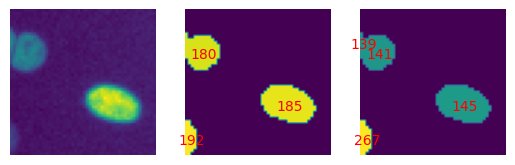

313 293
114 881
475 860
820 411
654 712
845 576
762 438
680 726
533 777
380 440
856 86
245 234
385 715
127 151
237 659
547 277
386 53
385 63
301 707
304 64
180 793
907 638
776 99
321 778
14 802
897 962
958 142
841 736
96 888
682 372
253 198
103 688
452 930
7 129
398 195
734 488
22 459
571 420
902 622
300 38
223 667
316 137
622 40
438 429
23 715
374 830
83 566
352 631
687 577
340 830
111 917
406 617
373 82
328 290
699 355
699 35
340 518
864 401
534 10
882 346
561 53
127 467
315 939
300 486
53 948
56 411
360 756
49 601
53 975
162 844
415 781
392 580
604 939
39 74
790 301
119 878
176 584
278 411
802 189
200 230
565 208
115 859
893 906
843 291
139 655
455 214
868 805
761 99
161 192
877 941
239 436
610 302
784 203
746 754
275 739
467 279
917 49
874 828
413 580
188 537
196 413
400 312
448 440
889 256
127 363
199 68
196 626
962 571
386 488
627 268
320 50
787 785
520 775
405 434
182 337
774 736
948 750
195 727
111 704
484 808
331 562
803 911
954 691
358 22
540 941
31 474
563 267
976 903
111 44

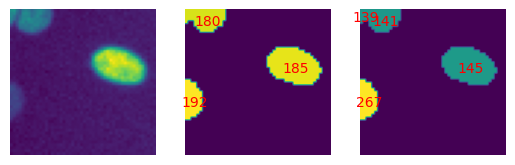

668 485
63 560
703 885
465 129
783 300
34 646
978 21
152 141
51 298
597 845
806 311
971 75
904 406
41 622
368 223
42 857
317 176
858 444
649 734
331 415
521 233
716 770
392 310
209 777
42 193
313 463
227 713
554 168
863 142
775 86
800 705
764 539
144 879
287 757
346 136
961 965
335 516
485 712
813 399
895 608
109 565
613 701
318 565
892 782
779 110
60 25
356 736
301 633
968 673
512 343
283 470
886 814
96 950
553 8
51 749
749 843
208 695
94 510
660 475
896 907
685 94
265 276
699 215
207 273
593 714
679 560
555 463
154 84
370 297
515 900
768 34
71 423
38 956
724 461
919 346
824 814
448 146
693 217
563 146
495 198
387 674
472 674
588 615
101 116
601 301
207 468
449 367
657 174
203 162
822 626
442 459
485 118
304 83
697 49
459 649
30 150
795 967
492 662
859 57
959 943
841 640
324 256
682 695
233 81
760 368
556 524
273 488
178 778
480 544
962 284
383 583
549 263
809 65
861 372
617 538
664 326
272 176
240 620
503 879
339 213
334 912
755 965
565 657
665 112
528 911
939 872
599 677
598 464
745

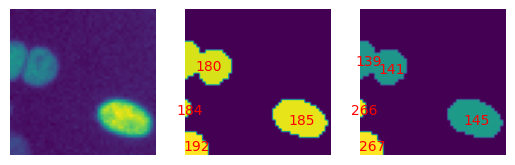

746 842
880 585
562 570
372 83
601 605
237 729
490 694
39 192
717 464
798 476
315 192
926 570
827 190
739 751
551 851
886 740
790 771
226 640
433 166
378 923
118 601
662 258
829 80
459 117
903 660
164 803
424 193
884 732
53 556
839 68
682 11
933 254
285 142
43 730
973 793
751 823
772 901
389 221
805 727
826 534
16 359
47 253
405 950
315 945
557 286
517 826
541 704
735 264
308 608
755 619
544 602
585 43
308 915
142 254
131 856
690 474
507 523
244 100
98 510
209 377
896 574
810 942
76 544
782 305
868 583
793 901
819 953
794 185
893 872
826 849
685 504
335 165
411 841
957 920
801 826
276 840
676 512
633 817
43 858
589 579
958 629
426 678
487 895
410 437
610 80
529 138
735 283
317 975
233 58
44 437
526 413
805 855
345 281
212 96
677 319
347 148
436 288
627 620
306 576
622 326
8 600
384 151
516 52
621 819
489 71
514 272
503 306
64 161
19 888
152 46
852 143
938 152
427 315
681 415
593 395
510 47
452 129
143 145
695 444
760 805
917 283
782 211
355 894
955 441
891 512
659 367
32 899
30 858
647

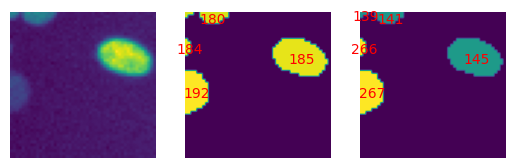

935 937
746 419
195 817
287 901
227 274
892 386
865 736
816 944
619 952
539 727
733 928
633 447
322 284
587 311
594 910
191 944
964 18
126 134
265 883
353 666
807 500
282 420
545 605
843 57
844 903
785 582
697 211
520 151
576 850
839 707
661 601
436 657
381 960
647 273
963 721
830 841
852 896
817 687
195 404
350 656
196 447
599 359
781 227
34 213
7 575
509 189
422 260
326 773
183 208
486 446
910 134
589 419
137 557
901 913
739 968
828 700
527 494
37 822
133 606
599 648
179 575
462 139
750 471
894 673
672 106
185 77
441 44
886 541
706 317
862 841
813 780
45 478
913 486
361 127
129 529
714 390
549 162
43 788
710 363
954 780
391 670
518 297
695 343
180 112
777 504
920 391
892 898
905 418
722 608
925 868
590 128
560 249
365 519
281 763
405 295
123 82
395 463
636 348
619 345
366 773
673 360
115 339
880 894
243 754
935 951
325 508
390 599
389 271
592 35
707 750
769 624
976 780
874 81
49 618
529 422
273 686
129 564
159 86
515 31
108 610
731 170
113 724
279 12
319 830
37 882
500 764
304 82
915

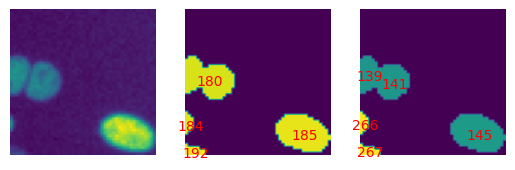

412 689
607 487
964 230
576 683
370 451
714 664
216 346
928 166
753 231
17 729
131 872
885 364
649 259
514 267
852 657
694 695
274 847
532 162
111 626
497 548
537 81
185 391
940 18
275 488
126 806
860 79
751 296
710 153
640 211
394 189
552 164
874 794
271 762
504 736
60 176
376 40
808 330
433 418
671 82
118 565
785 507
627 600
797 253
674 875
369 619
29 393
393 463
233 114
482 643
715 810
796 898
696 925
47 716
405 738
583 225
410 777
370 632
486 114
841 151
302 935
768 759
708 673
97 469
36 40
838 137
303 490
861 591
482 334
507 802
576 876
166 775
820 293
616 246
497 518
968 218
844 952
850 578
106 358
737 262
148 978
245 365
67 751
533 106
221 445
188 227
333 53
539 276
64 821
332 430
537 503
932 31
644 960
179 65
183 918
422 547
165 77
302 7
331 796
465 29
618 220
780 52
812 23
2 690
511 768
736 243
169 870
162 592
508 89
574 301
753 110
132 526
949 556
877 135
91 910
905 354
461 975
785 874
903 260
818 86
14 90
759 115
182 123
427 876
691 790
28 86
183 459
576 874
100 620
157 810


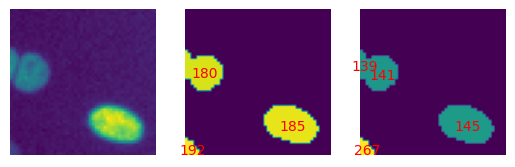

756 591
862 307
1 808
356 137
666 252
168 505
969 5
433 770
756 797
266 83
401 940
653 47
866 865
63 380
740 145
696 739
779 202
855 191
651 913
359 730
704 830
466 697
550 884
386 700
840 185
802 630
535 512
553 118
513 478
26 146
50 201
867 768
893 656
942 217
514 917
108 46
794 33
79 606
625 803
929 259
127 635
290 306
69 578
61 322
398 479
342 451
100 900
902 698
598 236
911 15
244 780
491 150
977 161
312 322
632 738
918 951
327 669
872 746
889 424
285 970
346 450
561 68
425 60
747 87
300 280
105 467
894 304
894 328
149 422
577 869
205 702
650 42
400 707
440 635
612 926
21 751
11 142
554 403
570 330
814 471
661 354
608 550
89 967
631 67
651 839
294 510
13 298
485 324
721 167
377 867
170 746
60 284
552 880
580 71
190 871
572 162
498 32
906 264
251 113
499 593
30 192
476 309
893 189
44 77
680 418
353 603
645 284
961 804
491 208
869 861
587 374
814 393
669 522
175 713
730 621
494 664
903 128
249 31
536 161
589 405
692 735
952 127
954 479
822 188
580 391
448 501
747 231
253 163
715 779

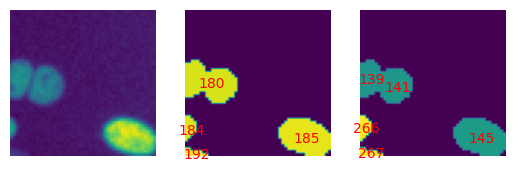

356 126
37 562
9 826
452 738
902 18
609 482
17 632
451 878
938 791
845 100
964 317
206 678
802 191
872 291
428 49
547 241
355 781
593 369
142 331
303 675
340 170
494 61
149 838
916 439
362 865
815 454
431 501
562 471
874 56
496 482
793 128
344 717
167 772
43 409
336 898
93 472
564 89
13 827
698 679
598 447
928 520
176 642
546 387
155 276
209 22
337 72
216 48
64 76
258 633
894 756
940 643
476 460
49 373
82 733
555 533
306 35
345 110
966 142
433 398
740 800
421 711
21 772
741 305
491 403
815 596
462 794
858 923
527 143
678 436
882 976
56 689
780 38
307 211
136 125
650 155
937 513
276 934
845 555
513 310
187 952
821 949
95 734
890 931
576 570
172 878
646 375
967 558
92 812
470 798
438 894
687 511
968 387
893 576
152 120
866 241
669 962
327 369
609 938
207 858
256 602
568 670
492 74
108 669
35 438
170 410
768 243
253 278
242 684
655 520
558 721
965 431
933 590
341 40
140 826
490 358
289 124
559 456
164 874
419 648
816 69
553 881
211 355
835 833
922 680
435 950
613 141
303 118
228 381
631 5

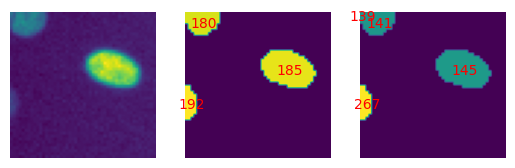

191 914
634 8
701 457
828 643
822 842
219 326
202 660
194 348
907 25
707 818
204 912
159 564
814 36
268 721
78 738
842 970
712 481
197 471
906 951
787 689
864 772
379 716
579 533
908 260
258 156
763 830
437 152
554 806
890 835
710 547
500 546
926 600
175 967
74 129
512 422
217 637
534 979
191 95
360 262
191 214
838 597
385 924
289 390
42 567
228 628
291 23
48 715
580 759
96 132
596 810
274 141
938 788
328 216
299 321
544 192
218 229
795 345
23 42
472 955
706 583
902 867
334 156
678 642
356 594
667 956
130 564
485 507
758 44
295 75
407 743
254 831
225 111
342 887
310 674
663 112
519 347
786 848
95 355
561 955
700 192
726 24
798 857
338 235
111 77
593 317
157 531
892 390
739 153
726 876
969 486
534 197
373 585
324 16
654 649
349 828
935 842
945 906
450 146
669 646
710 116
16 493
594 900
261 825
183 86
259 748
146 383
541 415
857 741
768 491
610 698
38 344
291 375
894 401
568 198
72 463
954 518
94 268
28 445
713 957
230 220
489 968
146 322
910 809
405 270
764 760
861 471
43 295
900 637
62

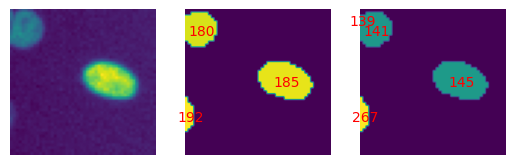

800 702
649 694
215 942
752 831
113 335
2 288
802 130
960 156
860 404
406 490
701 929
329 479
406 569
725 497
564 525
348 757
364 339
958 225
78 415
211 126
182 584
656 967
44 171
24 972
686 177
788 286
538 231
108 147
884 831
242 587
143 267
928 391
824 69
53 129
381 484
472 405
243 391
0 853
39 331
923 803
881 491
762 772
596 308
648 955
165 923
714 919
390 214
908 477
893 235
430 434
135 798
801 12
487 602
837 920
500 407
426 257
139 877
654 504
202 566
497 734
101 779
938 188
423 300
374 425
100 131
376 940
877 758
483 958
182 501
400 597
606 343
734 803
109 825
459 630
745 831
875 287
932 73
485 894
725 260
679 366
676 381
418 785
60 287
110 432
260 152
334 121
560 429
539 461
107 552
38 212
439 185
1 956
327 402
30 140
757 470
69 804
605 416
797 637
351 566
397 743
764 271
360 300
152 224
824 851
104 266
329 60
375 488
621 772
569 225
100 606
560 250
286 480
253 354
681 325
546 122
100 977
312 155
691 716
145 253
514 874
742 61
236 840
528 614
103 274
645 731
64 511
581 786
769 5

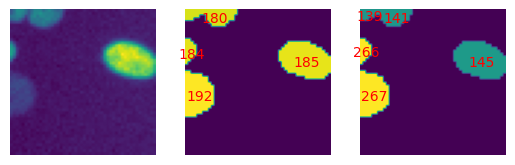

193 187
663 47
527 295
94 185
340 348
299 68
506 175
507 81
773 98
356 888
373 736
960 390
362 628
533 280
118 450
391 892
821 20
279 191
799 394
692 976
798 784
765 403
669 647
784 335
249 216
25 913
906 101
413 813
669 866
774 791
817 688
288 765
683 837
840 602
501 537
497 779
669 762
965 565
303 722
709 511
754 47
762 142
292 949
275 784
195 640
55 477
467 171
297 196
305 670
5 950
8 23
12 344
439 975
677 422
869 252
796 657
217 32
238 679
948 305
210 911
794 532
126 898
828 975
160 540
609 713
653 525
529 449
925 819
294 323
967 603
400 765
900 22
443 829
87 556
301 576
725 52
860 696
143 134
913 868
961 692
249 532
675 889
896 329
313 949
72 869
123 303
836 631
811 730
556 293
784 964
242 975
771 790
692 433
252 433
409 941
53 143
523 588
114 591
664 755
830 592
271 871
940 681
612 683
952 804
865 131
328 235
34 164
167 522
299 528
745 614
268 549
791 493
570 897
310 175
210 396
945 960
917 804
37 520
625 406
480 617
59 701
186 560
493 302
56 744
974 639
73 17
318 347
317 922
464

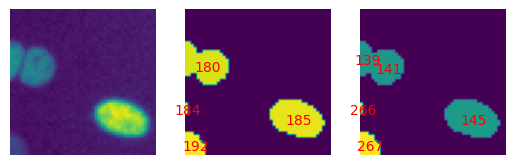

66 757
161 369
466 587
802 913
863 552
503 842
501 964
331 431
355 752
962 659
919 172
371 496
338 654
538 405
390 270
153 959
752 869
459 961
34 10
706 448
136 262
510 268
614 596
455 664
336 418
649 229
183 621
53 811
957 214
62 961
967 825
701 587
122 462
752 731
644 927
886 2
735 965
851 429
735 369
567 942
948 741
135 659
642 54
937 866
755 206
32 578
438 823
921 230
720 17
289 123
810 945
656 414
564 192
38 194
844 265
944 408
8 401
502 678
122 524
271 399
407 422
847 138
832 105
923 85
552 206
790 319
367 719
886 486
939 260
584 649
632 71
302 76
195 21
779 330
391 286
824 450
359 44
174 72
728 223
197 957
88 457
853 407
78 717
151 937
320 394
254 689
429 600
233 162
268 252
442 252
300 375
66 701
669 962
944 688
636 818
168 314
704 889
820 476
625 694
488 936
970 742
884 933
174 746
925 667
496 144
822 597
344 744
684 208
306 811
781 926
445 251
627 127
441 328
892 788
334 915
482 743
682 565
63 370
573 20
620 878
974 801
698 288
390 272
231 191
928 800
708 102
35 499
702 308
6

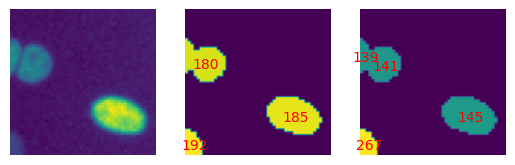

130 893
923 380
486 581
589 897
504 645
461 695
538 586
932 228
550 836
217 561
63 347
838 359
516 577
520 168
454 159
739 782
46 701
734 473
384 971
614 407
160 710
125 915
859 625
777 787
12 468
212 318
94 959
633 245
667 161
685 451
371 882
408 851
738 3
878 770
672 669
587 580
12 280
286 142
416 492
782 813
676 295
752 664
336 266
954 218
784 33
25 389
317 624
976 779
302 196
312 622
429 903
196 660
764 552
692 622
720 933
329 115
200 929
545 185
119 489
213 402
481 533
788 536
951 842
943 518
850 196
588 45
520 915
274 711
523 538
787 156
213 0
6 503
74 154
63 748
494 720
463 497
612 369
491 571
782 286
17 126
473 445
524 745
559 774
350 212
212 648
45 764
165 23
890 484
967 642
14 220
159 930
237 781
0 759
563 368
55 843
414 233
403 464
353 760
928 522
233 232
372 967
275 848
678 809
62 882
802 415
342 189
59 52
975 278
635 800
136 101
609 344
470 420
13 617
39 429
904 812
381 896
181 119
591 814
338 677
184 683
366 950
905 496
90 889
950 257
103 469
738 944
206 750
710 668
634 5

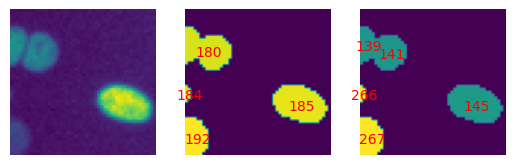

596 842
675 469
343 949
471 655
886 63
319 12
74 180
432 20
756 137
423 606
39 874
525 354
335 779
503 668
925 918
291 939
161 954
693 476
15 775
576 376
747 904
221 351
623 959
46 125
827 329
570 375
111 655
392 475
737 833
669 822
150 238
220 877
771 449
904 920
397 198
632 926
445 554
476 360
930 341
917 190
657 359
685 846
123 108
80 427
180 850
912 708
102 488
806 126
801 352
957 917
972 348
282 314
291 867
885 589
609 628
75 893
380 725
104 979
697 397
406 175
871 805
79 504
369 817
880 604
792 497
322 5
854 562
225 317
64 32
660 231
177 423
873 508
923 284
129 397
150 487
693 737
516 724
338 965
186 263
83 317
881 422
388 728
858 510
110 865
562 180
123 200
119 315
825 400
104 454
92 179
247 248
609 208
20 337
95 681
614 321
777 678
346 246
741 482
327 71
938 396
82 32
759 621
76 75
475 643
356 570
68 687
509 510
33 535
379 324
192 649
155 204
972 133
575 142
555 310
685 958
84 410
311 888
443 538
186 841
751 681
716 665
651 720
858 691
174 309
122 954
458 238
196 70
696 656
714

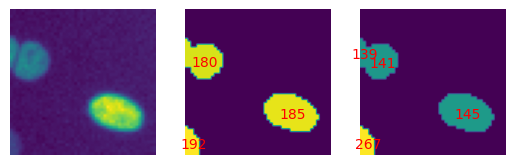

713 139
146 97
153 58
306 185
52 434
50 724
261 468
727 170
781 684
398 791
662 370
254 204
399 907
100 822
821 615
374 226
700 577
102 278
387 184
924 817
675 571
453 801
850 193
323 190
504 336
227 560
460 449
133 661
61 751
576 2
243 115
522 190
276 306
384 498
388 970
276 757
423 479
292 245
61 329
224 253
216 691
412 81
754 844
370 875
629 964
886 120
737 833
378 295
257 16
183 829
493 440
374 732
497 954
386 645
652 417
120 277
106 233
877 853
326 820
277 848
788 724
943 347
827 392
617 806
89 384
546 792
46 690
910 549
421 361
610 222
617 441
191 960
24 420
513 734
593 189
667 877
488 443
529 776
613 309
832 197
131 183
607 642
350 900
35 56
256 251
248 758
100 398
553 665
337 258
970 809
826 61
620 90
251 786
470 972
529 395
842 58
144 196
835 944
885 396
131 367
444 745
843 380
648 904
119 108
99 878
58 915
144 499
325 749
138 197
35 869
101 35
740 75
639 117
182 836
749 514
587 590
248 159
491 861
642 443
452 82
339 711
307 608
100 754
146 60
894 829
748 229
832 222
521 58
84

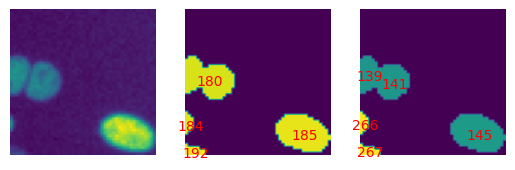

213 804
195 714
587 242
544 369
280 825
207 656
201 27
794 224
48 463
394 501
228 951
109 815
129 703
915 45
792 907
658 547
121 857
259 728
690 832
30 325
625 276
427 721
810 367
960 643
220 551
101 158
554 457
734 952
591 664
652 342
300 750
222 787
158 481
381 84
97 512
446 520
241 843
213 362
700 864
32 68
438 553
609 594
818 170
845 234
381 133
794 119
17 610
868 120
965 941
727 793
912 637
166 746
427 119
258 106
403 839
554 49
875 330
111 406
811 237
464 99
262 497
940 558
638 395
881 370
847 225
360 602
252 598
365 514
501 789
918 722
683 303
812 761
491 546
738 889
198 337
439 716
79 292
817 947
791 142
890 395
620 595
554 470
541 168
95 166
399 488
209 44
946 730
751 851
601 739
197 739
367 77
799 334
741 794
972 650
909 239
812 720
102 856
45 629
6 19
786 701
86 119
772 817
71 788
122 248
486 390
957 22
356 239
142 254
409 240
762 329
626 295
12 225
656 859
240 801
44 113
318 640
606 57
470 567
356 463
466 792
88 5
749 911
970 216
797 73
30 150
320 491
559 514
353 689
239 27

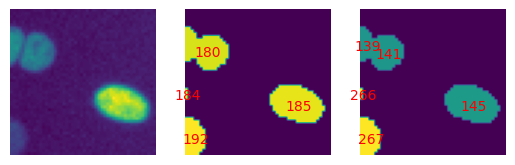

298 342
64 370
396 641
661 268
358 121
205 462
27 690
891 407
326 64
27 69
653 444
341 170
37 673
589 609
196 457
23 359
718 223
970 675
398 97
819 777
577 728
248 331
188 375
847 13
630 742
936 190
72 174
287 634
721 51
692 686
309 119
561 6
478 638
513 588
594 86
281 814
265 951
476 332
337 84
677 472
736 939
623 812
165 874
876 193
741 512
797 919
891 381
662 225
532 354
534 342
605 458
208 434
776 960
240 908
661 99
307 896
75 592
431 286
446 921
367 860
533 720
707 242
706 844
354 126
422 557
624 859
205 323
162 152
600 63
194 339
744 24
488 673
224 110
343 133
360 780
108 760
722 71
763 48
937 195
273 973
115 656
201 864
280 85
2 646
571 218
538 344
370 449
563 885
77 380
425 251
137 786
927 83
353 391
555 146
372 131
179 852
610 624
482 234
880 623
403 450
924 653
201 243
219 515
725 848
838 782
714 384
491 209
866 11
848 289
542 569
276 443
546 337
468 607
228 185
858 718
927 685
502 327
879 715
503 440
23 403
633 635
42 976
795 917
972 356
832 79
370 301
265 33
145 494
796 921

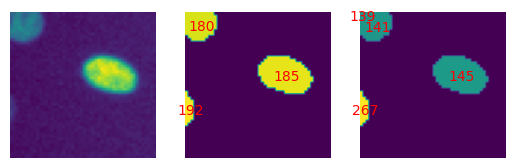

582 78
558 490
339 720
460 135
951 376
43 374
238 732
192 506
306 71
752 142
348 768
618 515
851 684
348 494
861 172
845 919
556 339
787 499
398 100
721 56
17 362
845 812
317 734
718 326
83 524
55 686
216 578
44 511
416 215
435 696
312 400
692 264
97 249
957 349
741 683
968 107
313 344
819 70
719 539
227 536
97 617
213 336
606 640
176 900
605 471
631 286
827 56
433 843
829 888
915 215
100 455
877 904
325 486
623 537
619 430
250 41
268 100
681 278
811 841
835 777
616 597
127 716
45 603
215 859
172 17
28 258
327 4
185 789
451 325
885 967
561 511
541 497
889 660
868 264
413 53
144 891
846 847
316 736
797 356
591 314
972 650
800 809
380 476
767 260
751 656
792 871
490 728
342 758
175 354
858 681
193 135
590 593
193 391
55 329
914 786
340 808
500 570
344 41
529 4
352 228
467 953
586 716
859 617
179 85
689 547
761 739
99 803
551 812
835 903
213 920
512 222
487 378
904 56
586 348
318 836
848 732
778 955
380 355
128 781
329 19
514 876
475 269
410 333
610 389
283 334
548 507
14 598
904 583
609 

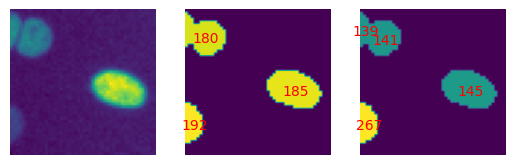

369 68
958 372
626 674
157 410
648 312
305 497
711 251
277 735
302 48
262 507
473 691
175 843
804 335
253 157
522 88
917 328
689 813
72 975
584 711
70 613
67 292
206 675
266 790
418 616
586 662
884 520
932 31
443 875
285 512
220 328
834 737
747 415
476 174
534 60
971 482
335 354
92 104
801 25
255 922
879 484
167 279
902 515
58 100
27 233
563 800
728 727
634 266
974 699
116 708
716 153
777 626
853 239
943 344
569 148
890 347
35 786
958 903
299 842
811 903
117 628
972 843
492 10
906 596
296 328
519 933
937 92
738 873
597 382
374 738
853 162
443 71
880 979
114 910
550 341
362 399
475 377
368 576
290 97
519 685
584 598
33 557
431 761
276 247
734 912
939 199
547 942
123 152
891 467
464 903
118 113
556 250
115 402
889 16
163 256
866 483
820 920
792 131
578 853
870 785
650 929
539 768
874 368
458 244
378 559
588 258
757 933
581 805
94 205
924 119
30 82
705 756
714 808
559 405
454 460
562 521
191 699
620 368
483 737
657 248
552 580
658 902
418 949
295 922
211 791
171 621
870 48
825 458
385 786

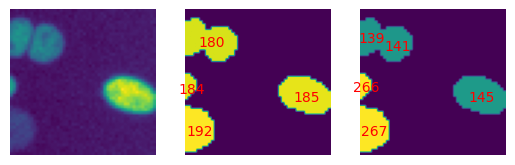

151 171
660 560
552 436
571 681
931 528
315 929
850 394
274 613
361 748
143 229
519 632
25 510
510 144
969 647
633 236
975 407
23 186
417 337
494 855
292 608
41 3
238 604
333 561
847 17
838 730
557 608
430 460
789 769
663 880
112 897
348 626
218 897
105 740
261 56
543 197
878 782
806 357
465 389
172 646
796 139
141 370
46 904
548 694
926 708
276 758
129 621
632 315
432 65
682 934
301 112
664 696
634 896
676 110
468 118
4 47
114 88
773 489
528 471
322 125
475 975
686 183
872 476
930 2
609 928
714 209
164 237
958 646
461 863
596 559
536 854
524 692
241 397
560 165
598 138
474 753
187 220
725 525
538 671
836 563
570 116
153 775
253 42
207 607
961 794
166 826
211 939
582 971
85 404
841 289
460 575
674 892
109 800
157 416
960 394
14 780
316 108
330 877
47 941
227 859
10 835
300 864
447 959
247 927
974 473
512 349
263 49
132 229
355 208
530 520
73 939
367 451
677 653
379 657
535 525
829 730
762 517
278 757
297 343
690 430
489 287
324 229
870 833
875 901
277 763
512 919
708 957
801 915
738 34

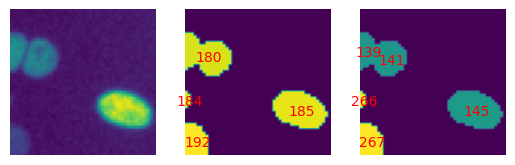

431 172
491 240
94 683
290 364
98 696
189 24
245 370
40 336
495 660
357 497
652 727
295 240
649 691
604 756
307 656
821 969
462 325
101 757
708 865
368 957
622 265
257 439
37 648
707 190
166 349
583 898
368 238
77 879
852 174
751 162
213 386
722 698
606 24
748 806
217 759
423 393
512 731
269 181
946 238
869 697
395 449
214 204
101 868
213 769
664 598
594 641
872 595
189 953
629 966
758 903
264 820
595 202
802 538
965 508
655 105
498 768
600 404
241 797
808 111
162 611
446 850
503 867
493 230
611 730
189 448
881 315
616 885
906 486
558 274
812 30
767 469
364 620
402 928
860 611
130 891
817 641
322 288
590 408
644 564
353 958
548 377
744 320
773 728
937 16
308 812
608 964
165 565
124 279
900 508
504 88
788 488
507 9
17 235
729 956
479 24
787 322
259 77
444 628
239 134
920 344
590 588
206 68
631 801
137 480
426 484
959 763
53 679
324 699
607 433
617 564
485 896
53 144
185 750
24 34
281 76
934 717
680 180
700 609
218 445
432 421
720 367
640 813
456 27
342 121
845 836
452 391
957 140
62 89


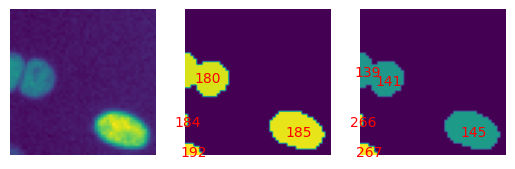

132 202
388 18
120 483
963 405
50 725
302 410
753 82
673 374
369 863
399 450
30 677
286 308
975 232
889 853
602 62
111 75
275 919
806 879
476 668
650 702
764 524
368 2
729 496
16 362
608 6
625 405
747 424
736 159
512 316
461 235
302 824
710 937
226 684
853 24
969 283
549 814
486 670
38 974
458 463
314 317
591 802
225 238
968 966
836 301
480 820
856 903
162 694
339 963
625 470
588 476
78 758
113 483
334 411
507 819
791 658
723 151
413 675
781 175
202 258
414 648
15 374
277 778
637 161
484 867
65 298
219 670
204 634
299 622
407 33
192 957
811 75
663 69
474 807
93 810
327 690
954 110
476 416
669 510
213 554
358 295
857 412
76 518
97 699
829 979
133 272
620 536
79 831
768 594
74 962
767 463
9 669
454 797
678 540
380 62
884 279
921 219
205 860
819 222
854 70
580 354
590 584
475 571
606 390
679 36
945 123
100 357
59 110
774 74
402 408
860 375
325 47
618 743
930 385
324 462
585 673
551 322
537 455
843 868
771 116
433 698
852 69
513 295
360 868
545 519
410 503
828 786
603 602
603 960
142 633
3

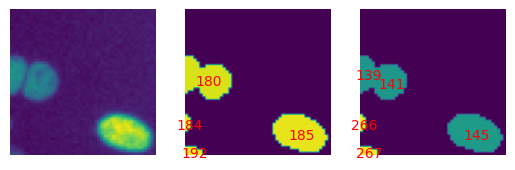

901 616
398 387
402 260
916 513
856 205
262 313
499 206
942 213
141 689
550 662
629 293
316 370
264 736
879 839
213 94
506 868
327 336
640 295
146 970
732 375
275 837
61 664
970 174
575 384
20 558
270 274
764 25
277 501
10 713
840 908
107 26
747 349
172 204
309 910
60 970
698 3


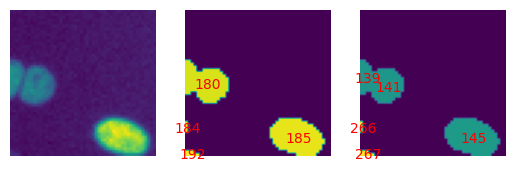

898 341
0 637
960 785
490 173
749 52
243 746
16 242
380 399
252 539
129 481
527 348
429 832
543 160
730 568
217 95
644 374
841 402
546 250
477 114
262 932
183 236
838 914
85 575
31 308
61 751
788 761
168 312
134 774
117 308
366 38
338 222
290 586
261 451
333 678
39 799
743 39
273 966
414 423
232 858
833 100
845 526
956 174
647 707
725 616
815 133
933 459
38 822
161 250
42 115
674 945
786 191
588 496
979 167
932 679
969 317
776 634
150 803
533 463
647 390
402 762
479 855
274 185
864 142
628 786
838 245
422 797
410 21
519 527
839 316
143 780
395 27
608 334
168 732
50 529
44 931
719 930
749 954
174 649
804 504
322 190
355 551
444 138
615 386
710 273
504 634
187 716
861 928
413 644
709 42
639 847
974 650
728 254
832 632
488 407
416 917
675 804
522 51
938 286
448 918
60 124
82 586
118 374
280 274
800 40
216 564
585 902
121 603
425 585
684 649
64 878
553 348
157 715
483 789
32 5
830 932
446 314
226 157
508 158
14 965
45 740
229 209
468 544
349 971
65 378
379 607
352 537
430 388
723 849
178 1

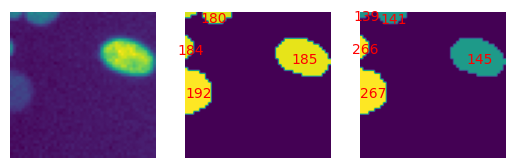

574 784
627 41
606 682
331 760
629 550
194 36
481 952
530 386
250 934
0 508
583 285
775 65
265 754
769 28
495 287
486 13
819 101
541 969
735 546
634 661
840 380
843 407
247 176
928 365
637 411
952 163
431 597
329 695
320 672
61 972
538 251
445 227
635 703
326 708
629 66
688 834
193 14
978 242
846 43
576 654
327 335
132 137
377 346
663 509
833 68
878 217
678 663
722 119
895 797
264 703
82 930
241 679
734 540
386 307
538 801
919 789
223 599
904 891
105 404
181 123
399 231
607 167
159 472
825 654
339 403
686 688
953 327
713 583
250 64
802 548
216 247
668 840
608 510
842 429
933 368
524 968
870 541
172 453
631 157
345 224
509 14
339 721
844 252
772 854
369 740
954 239
455 634
628 8
542 584
755 20
444 178
18 23
685 59
330 234
25 731
488 122
554 63
299 787
788 326
160 495
975 75
361 707
326 34
404 594
466 579
205 618
476 455
576 955
100 534
439 246
862 523
466 552
123 278
733 837
740 316
823 61
711 890
607 394
376 496
490 795
931 104
114 306
352 287
812 180
335 501
501 14
583 513
612 813
109

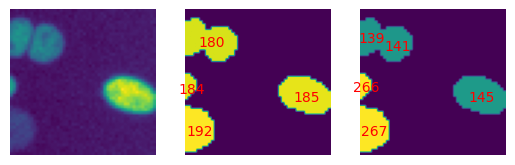

955 161
436 180
16 433
397 25
150 79
394 966
308 689
748 124
702 469
783 761
210 478
943 118
480 138
753 309
59 502
447 75
308 72
662 251
508 513
789 94
749 668
701 892
313 48
455 876
433 441
547 200
14 89
501 557
921 364
292 395
932 118
700 553
684 610
609 14
68 51
959 755
941 128
779 625
242 283
144 198
945 264
332 40
163 714
176 284
161 50
399 507
744 428
359 558
824 58
227 731
910 879
668 935
841 375
360 749
797 819
422 963
935 459
787 620
440 85
773 241
780 743
4 210
865 493
878 287
132 22
422 5
884 178
443 59
101 207
555 334
535 198
623 715
814 964
389 330
673 460
961 79
85 429
833 62
426 172
156 37
795 8
865 442
951 323
659 264
70 731
680 184
701 866
17 775
381 741
366 946
843 210
540 765
78 602
165 425
467 934
511 192
277 769
956 708
18 719
436 205
703 514
963 38
568 697
806 583
460 897
436 137
476 460
851 474
525 325
293 854
322 588
850 388
548 564
853 252
66 56
281 295
36 658
505 4
36 977
442 841
888 915
127 287
231 357
931 592
691 699
40 693
865 59
188 102
638 123
417 603
36

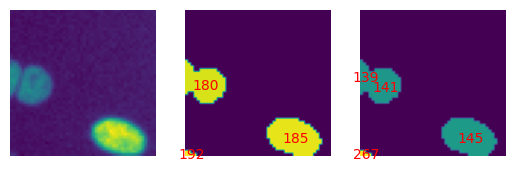

24 392
397 816
416 289
489 58
861 972
433 770
225 765
936 694
359 228
902 960
812 954
904 402
608 318
368 375
439 643
898 806
190 332
252 625
443 920
426 337
909 859
151 509
718 908
196 942
344 365
335 852
229 25
748 558
490 720
692 688
775 125
825 343
211 662
38 792
168 803
224 174
717 578
583 604
264 345
268 912
381 641
203 758
296 556
968 271
530 932
699 413
523 99
493 248
607 876
435 707
329 2
355 796
173 69
178 903
342 213
873 182
563 6
622 267
148 425
684 957
118 289
553 70
863 855
275 256
863 665
612 180
612 692
473 447
482 954
113 613
141 583
311 613
582 383
811 266
312 429
105 107
417 203
541 776
48 465
744 501
724 38
291 738
186 922
501 688
469 483
692 520
565 733
762 682
955 876
517 320
486 85
423 657
16 282
818 584
26 362
570 827
135 596
311 834
94 122
838 111
545 785
390 50
531 834
459 762
588 589
589 592
382 925
180 897
67 185
539 84
127 683
393 628
296 317
334 915
124 402
756 354
750 881
774 464
595 92
533 262
128 600
210 860
976 14
142 687
405 48
407 878
5 224
841 469
6

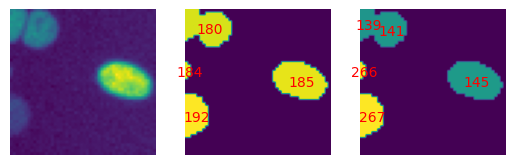

802 422
326 445
0 127
303 634
718 237
341 958
728 765
866 918
892 638
367 248
41 684
523 10
846 424
289 50
384 201
403 590
917 316
87 479
414 590
304 923
723 847
849 478
594 356
318 601
772 708
68 408
164 451
810 589
975 916
836 1
11 719
40 477
308 638
979 897
735 879
927 46
85 176
567 867
573 844
514 949
233 209
859 365
899 75
100 796
488 416
795 479
480 830
92 143
594 715
861 34
206 669
402 355
459 915
30 472
277 352
839 692
850 168
434 297
629 73
475 48
213 596
604 654
757 671
159 663
974 699
656 12
868 611
893 105
772 883
64 628
948 917
938 756
116 528
346 743
810 428
415 221
790 336
344 233
299 868
517 44
903 48
198 297
887 821
728 685
895 784
716 649
313 336
639 251
875 477
266 552
23 563
458 901
797 760
350 553
547 544
641 502
82 510
698 384
800 634
703 800
65 964
64 32
849 507
699 739
41 64
378 452
939 637
611 603
923 599
96 914
545 365
377 54
717 693
403 973
436 307
910 453
434 500
829 469
257 766
334 435
706 308
941 509
680 260
118 934
56 690
656 919
592 450
218 253
231 623
4

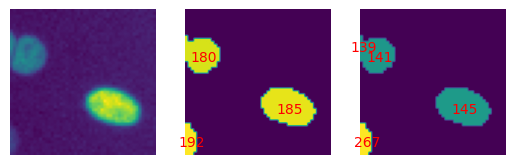

317 799
244 61
494 524
870 289
632 952
847 167
705 499
14 583
646 481
134 331
556 264
449 402
180 562
743 466
476 661
577 465
156 434
485 904
124 930
842 774
938 233
894 303
112 814
297 884
23 769
740 71
281 264
862 78
664 693
759 217
116 659
363 250
33 734
533 213
245 377
78 503
753 498
824 131
422 695
676 522
100 518
629 420
552 224
483 21
369 310
889 565
543 34
309 320
129 442
434 572
879 330
448 217
237 193
252 185
523 203
407 966
564 500
567 623
791 356
924 140
914 791
198 455
331 258
440 784
15 748
393 477
353 808
576 310
671 548
338 476
276 451
159 461
75 429
486 545
317 527
415 267
736 191
827 500
99 156
796 66
645 99
873 32
646 435
608 56
119 112
447 761
538 671
537 644
797 342
367 884
925 494
159 659
426 641
81 611
917 71
474 29
665 332
783 968
520 911
204 451
253 836
159 282
410 640
328 0
865 619
311 768
857 237
748 480
764 223
865 561
109 905
770 231
569 100
185 40
45 188
590 881
263 926
9 830
47 279
764 374
627 9
767 841
521 781
606 505
88 707
679 281
270 952
447 196
623 1

In [211]:
#Take the images, the instances masks and the groundtruth masks and make 100 random crops and display them in a line and except for the images put their vmin to 0 and their vmax to the max value in that plot
def display_crops(images, instance_masks, gt_instance_masks, n_crops=100):
    for i in range(n_crops):
        #np.random.seed(41)
        x = np.random.randint(0, 980)
        y = np.random.randint(0, 980)
        print(x,y)
        size_of_crops = 50

        image_crop = images[x:x+size_of_crops, y:y+size_of_crops]
        im_crop = instance_masks[x:x+size_of_crops, y:y+size_of_crops]
        gt_im_crop = gt_instance_masks[x:x+size_of_crops, y:y+size_of_crops]

        #TODO: condition of minimum number of instances present in the crop to display it
        if len(np.unique(gt_im_crop)) < 2:
            continue
        #TODO: only plot the ones where the number of instances in the im_crop and gt_im_crop are not the same
        if len(np.unique(im_crop)) == len(np.unique(gt_im_crop)):
            continue
        #TODO: minimum amount of pixels in the crop otherwise don't show it
        if len(np.where(im_crop > 0)[0]) < 300:
            continue
        if len(np.unique(gt_im_crop)) == 1:
            continue
        if 133 in np.unique(im_crop):
            continue
        if 112 in np.unique(im_crop):
            continue
        if 101 in np.unique(im_crop):
            continue
        if 180 not in np.unique(im_crop):
            continue

        plt.subplot(1,3,1)
        plt.imshow(image_crop)
        plt.axis('off')

        plt.subplot(1,3,2)
        #find the center of each value in the instance mask and plot it on the center of that value
        for j in np.unique(im_crop)[1:]:
            x_center = np.mean(np.where(im_crop == j)[0])
            y_center = np.mean(np.where(im_crop == j)[1])
            plt.text(y_center-4, x_center+2, str(j), color='r')
        plt.imshow(im_crop, vmin=0, vmax=np.max(im_crop))
        plt.axis('off')

        plt.subplot(1,3,3)
        for j in np.unique(gt_im_crop)[1:]:
            x_center = np.mean(np.where(gt_im_crop == j)[0])
            y_center = np.mean(np.where(gt_im_crop == j)[1])
            #print(x_center, y_center)
            plt.text(y_center-4, x_center+2, str(j), color='r')
        plt.imshow(gt_im_crop, vmin=0, vmax=np.max(gt_im_crop))
        plt.axis('off')
        plt.show()
#pad_image = np.pad(images[1], (10,), mode='constant')
display_crops(images[0], instance_masks[0], gt_instance_masks[0],n_crops=100000)

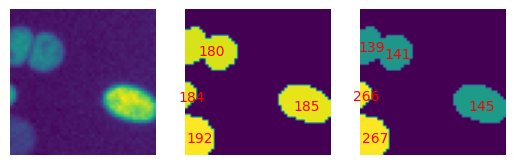

In [219]:


x, y = 709, 0
size_of_crops = 50

image, instance_mask, gt_instance_mask = images[0], instance_masks[0], gt_instance_masks[0]

image_crop = image[x:x+size_of_crops, y:y+size_of_crops]
im_crop = instance_mask[x:x+size_of_crops, y:y+size_of_crops]
gt_im_crop = gt_instance_mask[x:x+size_of_crops, y:y+size_of_crops]

plt.subplot(1,3,1)
plt.imshow(image_crop)
plt.axis('off')

plt.subplot(1,3,2)
#find the center of each value in the instance mask and plot it on the center of that value
for j in np.unique(im_crop)[1:]:
    x_center = np.mean(np.where(im_crop == j)[0])
    y_center = np.mean(np.where(im_crop == j)[1])
    plt.text(y_center-4, x_center+2, str(j), color='r')
plt.imshow(im_crop, vmin=0, vmax=np.max(im_crop))
plt.axis('off')

plt.subplot(1,3,3)
for j in np.unique(gt_im_crop)[1:]:
    x_center = np.mean(np.where(gt_im_crop == j)[0])
    y_center = np.mean(np.where(gt_im_crop == j)[1])
    #print(x_center, y_center)
    plt.text(y_center-4, x_center+2, str(j), color='r')
plt.imshow(gt_im_crop, vmin=0, vmax=np.max(gt_im_crop))
plt.axis('off')
plt.show()

In [12]:
import PySimpleGUI as sg
import numpy as np
import io
from PIL import Image
from io import BytesIO
import PIL

def array_to_data(array):
    im = Image.fromarray(array)
    #new_width = 400
    #new_height = 400
    #scale = min(new_height/108, new_width/108)
    #im = im.resize((int(108*scale), int(108*scale)), PIL.Image.ANTIALIAS)
    with BytesIO() as output:
        im.save(output, format="PNG")
        data = output.getvalue()
    return data




# Define the layout of the GUI
layout = [
    [sg.Image(data='', key='-IMAGE-')],
    [sg.Button('Keep'), sg.Button('Discard')],
    [sg.Text('Kept: 0   Discarded: 0', key='-COUNTER-')]
]

# Create the window
window = sg.Window('Image Viewer', layout, finalize=True)

# Define the lists for keeping and discarding images
keep_list = []
discard_list = []

# Loop over the images
images = image_crops  # replace with your numpy arrays
for image in images:
    # Convert the numpy array to bytes and update the image in the GUI
    #bio = io.BytesIO()
    #np.save(bio, image)
    window['-IMAGE-'].update(data=array_to_data(image))

    # Wait for a button press
    event, values = window.read()

    # Handle the button press
    if event == 'Keep':
        keep_list.append(image)
    elif event == 'Discard':
        discard_list.append(image)

    # Update the counters in the GUI
    window['-COUNTER-'].update('Kept: {}   Discarded: {}'.format(len(keep_list), len(discard_list)))

# Close the window
window.close()

In [96]:
indices = []
for i in range(len(keep_list)):
    for j in range(len(image_crops)):
        print(j)
        if (keep_list[i] == image_crops[j]).all():
            indices.append(j)
            break
print(indices)

0
0
1
0
1
2
0
1
2
3
4
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[0, 1, 2, 4, 6, 13, 14, 15, 16, 17, 19, 20, 23, 24, 29]


In [97]:
def equidistant_list(input_list):
    # Sort the input list in ascending order
    sorted_list = sorted(input_list)

    # Calculate the minimum and maximum values in the input list
    min_val = sorted_list[0]
    max_val = sorted_list[-1]

    # If all values in the input list are the same, return a list of zeros
    if min_val == max_val:
        return [0] * len(input_list)

    # Calculate the distance between adjacent values in the sorted list
    distance = (max_val - min_val) / (len(input_list) - 1)

    # Generate the output list by spacing out the values as far as possible
    output_list = []
    current_val = min_val
    for i in range(len(input_list)):
        output_list.append(int(round((current_val - min_val) / (max_val - min_val) * 255)))
        current_val += distance

    return output_list

0


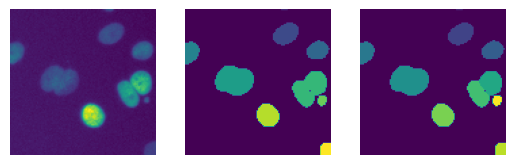

1


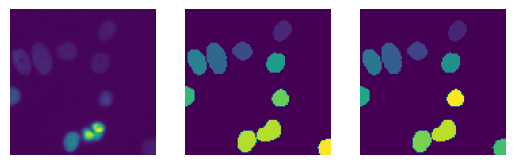

2


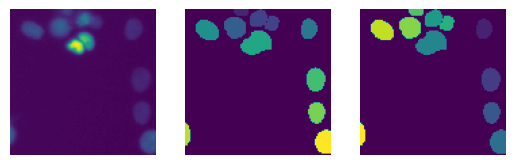

4


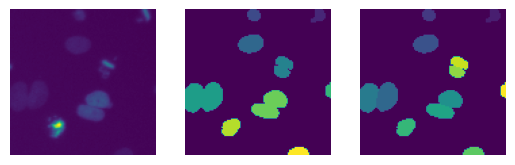

6


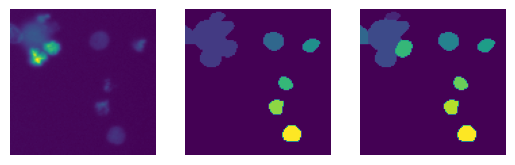

13


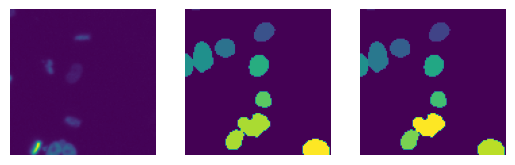

14


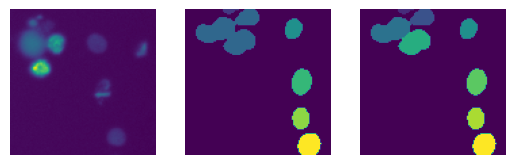

15


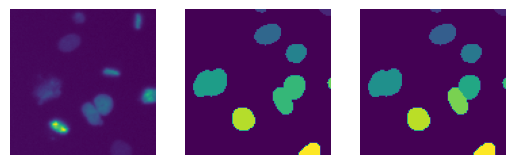

16


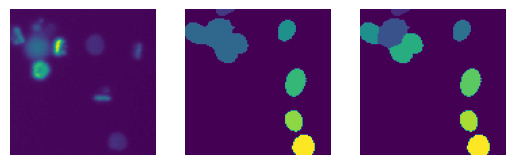

17


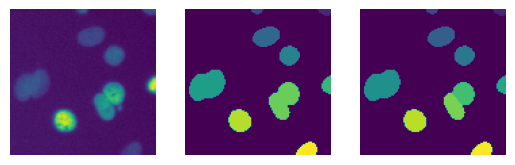

19


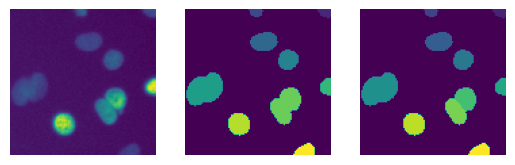

20


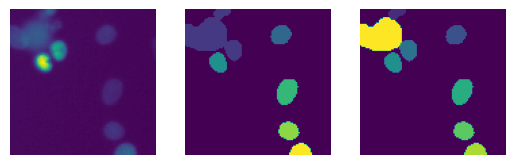

23


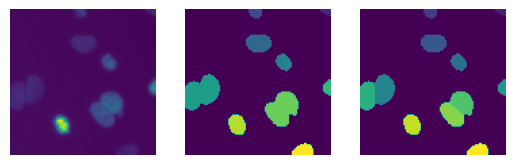

24


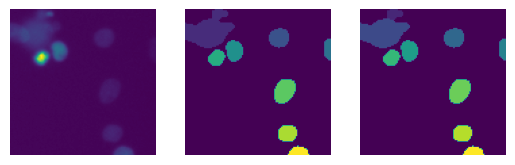

29


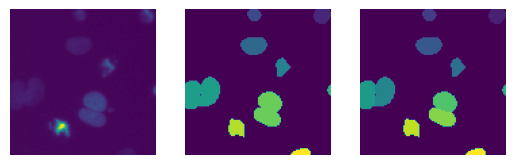

In [102]:
for i in indices:
    print(i)
    plt.subplot(1,3,1)
    plt.imshow(image_crops[i])
    plt.axis('off')


    plt.subplot(1,3,2)
    input = np.unique(im_crops[i])
    output = equidistant_list(np.unique(im_crops[i]))
    new_img = im_crops[i].copy()
    for j in range(len(output)):
        new_img = np.where(new_img == input[j], output[j], new_img)
    plt.imshow(new_img)
    plt.axis('off')


    plt.subplot(1,3,3)
    input = np.unique(gt_im_crops[i])
    output = equidistant_list(np.unique(gt_im_crops[i]))
    new_img = gt_im_crops[i].copy()
    for j in range(len(output)):
        new_img = np.where(new_img == input[j], output[j], new_img)
    plt.imshow(new_img)
    plt.axis('off')

    plt.show()


9


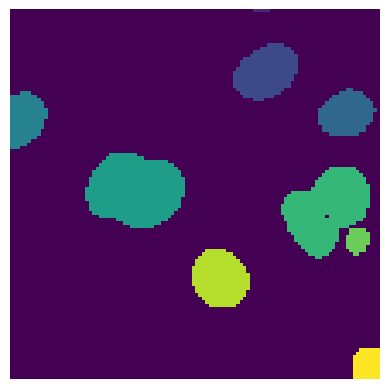

10


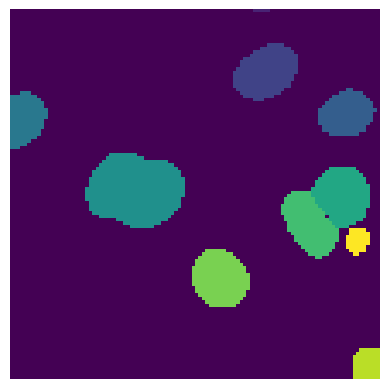

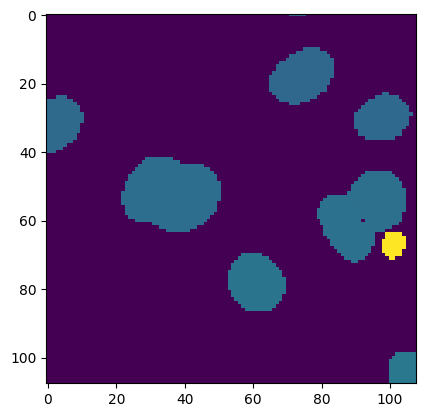

()


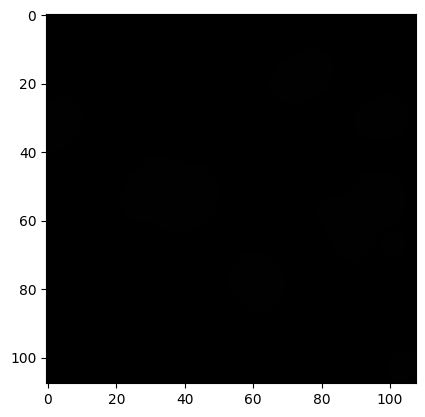

In [184]:
import cv2

import numpy as np
from scipy.ndimage import label
import matplotlib.pyplot as plt


print(len(np.unique(im_crops[0]))-1)
input = np.unique(im_crops[0])
output = equidistant_list(np.unique(im_crops[0]))
new_img = im_crops[0].copy()
for j in range(len(output)):
    new_img = np.where(new_img == input[j], output[j], new_img)
plt.imshow(new_img)
plt.axis('off')
plt.show()

print(len(np.unique(gt_im_crops[0]))-1)
input = np.unique(gt_im_crops[0])
output = equidistant_list(np.unique(gt_im_crops[0]))
new_img = gt_im_crops[0].copy()
for j in range(len(output)):
    new_img = np.where(new_img == input[j], output[j], new_img)
plt.imshow(new_img)
plt.axis('off')
plt.show()

params = cv2.SimpleBlobDetector_Params()
params.filterByCircularity = True
params.minCircularity = 0.001
params.filterByInertia = True
params.minInertiaRatio = 0.001
params.filterByArea = True
params.minArea = 1
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3 :
  detector = cv2.SimpleBlobDetector(params)
else : 
  detector = cv2.SimpleBlobDetector_create(params)
binary_mask = np.where(gt_im_crops[0] > 0, 1, 0).astype(np.uint8)
Gaussian = cv2.GaussianBlur(binary_mask, (21, 21), 0)
plt.imshow(gt_im_crops[0])
plt.show()
#inverted_img = cv2.bitwise_not(Gaussian)
keypoints = detector.detect(Gaussian.astype(np.uint8))
print(keypoints)
im_with_keypoints = cv2.drawKeypoints(binary_mask, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(im_with_keypoints)
plt.show()

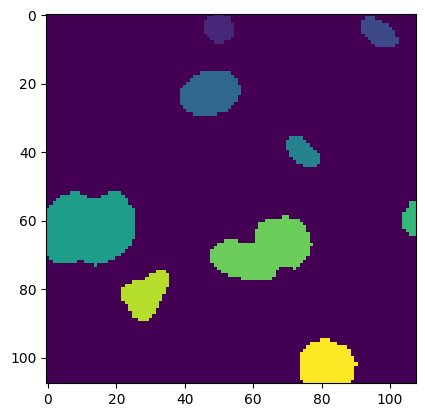

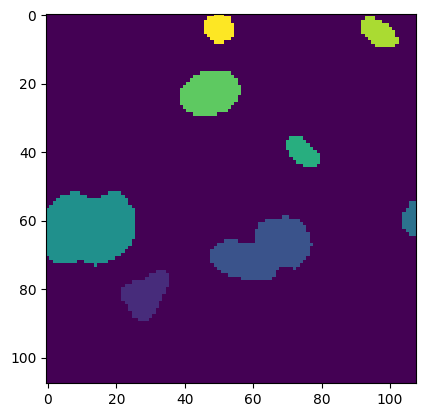

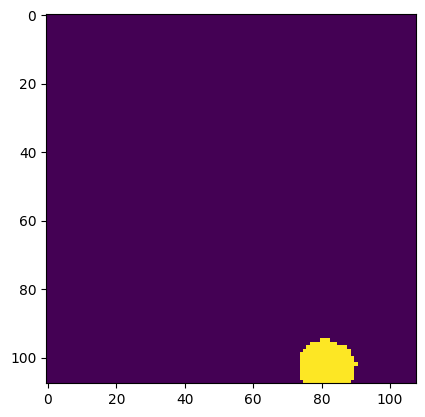

In [78]:
new_img_8bit = np.uint8(new_img * 255)
binarized = np.where(new_img_8bit == np.unique(new_img_8bit)[1], 255, 0).astype(np.uint8)
#print(np.unique(binarized))
contours, hierarchy = cv2.findContours(binarized, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

new_img_cont = new_img_8bit.copy()
new_img_cont = cv2.drawContours(new_img_cont, contours, -1, (0,10,0), 10)

plt.imshow(new_img)
plt.show()
plt.imshow(new_img_cont)
plt.show()
plt.imshow(binarized)
plt.show()
#print(contours)

#print(new_img_8bit.dtype)

In [53]:
np.unique(new_img)[0]

0

In [54]:
cnts = cv2.findContours(np.where(new_img==np.unique(new_img)[0],1,0), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


0
0
1
0
1
2
0
1
2
3
4
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[0, 1, 2, 4, 6, 13, 14, 15, 16, 17, 19, 20, 23, 24, 29]


In [ ]:
print(np.unique(keep_list[0))

In [ ]:
#Put the crops we selected through our instance algorithm

In [ ]:
#Display the original image crop, the instance segmentation we made and the groundtruth mask

In [ ]:
#We now have info to compare which method makes the "better" cell instances